Analysis of Vodafone users' fluxes

Ceren Yılmaz Gülten - 2080637
Feridun Cemre Gülten - 2080660

In [97]:
import numpy as np 
import pandas as pd 
import csv
import chardet
import matplotlib.pyplot as plt

After data collection, encoding needs to be done for each file. Since, each file have different encoding type, function provide efficiency and find proper encoding type and apply to each file. 

In [98]:
# Data Preparation 
# read and encoding all the related csv files to access data without any problem
def read_csv(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
        encoding = result['encoding'] # looking encoding type for each file because each datafile has different encoding type
    with open(file_path, 'r', encoding=encoding, newline='') as f: # with newline property end-of-lines problem is solved 
        reader = pd.read_csv(f)
        return reader
codici_istat_comune = read_csv('codici_istat_comune.csv')
codici_istat_provincia = read_csv('codici_istat_provincia.csv')
codici_nazioni = read_csv('codici_nazioni.csv')
day_od = read_csv('day_od.csv')
distinct_users_day = read_csv('distinct_users_day.csv')
population_italy = read_csv('population_italy.csv')



In [99]:
# transform the csv files data to dataframe to do analysis 
data_distinct = pd.DataFrame(distinct_users_day)
country_code = pd.DataFrame(codici_nazioni)
province_code = pd.DataFrame(codici_istat_provincia)
day = pd.DataFrame(day_od)
population = pd.DataFrame(population_italy)

In the first part, the goal is preparing cleaning the data and analysied the visitor data based on country based and provincia based. For that reason, the foreigner visitors number and Italian visitors number is used for this part. The application of the code was commented during the project.

In [100]:
#1.1
# to combine and access the country name based on country ocde 
data_distinct_country = data_distinct.merge(country_code[['COD_COUNTRY','COUNTRY_NAME_IT']])
# filter just foreigners to find visitors which are not Italian  
data_foreigner = data_distinct_country.loc[data_distinct_country['CUST_CLASS'] == 'foreigner']
# to reset the index to get index from 0 
data_foreigner=data_foreigner.reset_index(drop=True)
# groupby total visitors based on the country name 
df_foreign = data_foreigner.groupby('COUNTRY_NAME_IT')['VISITORS'].sum()

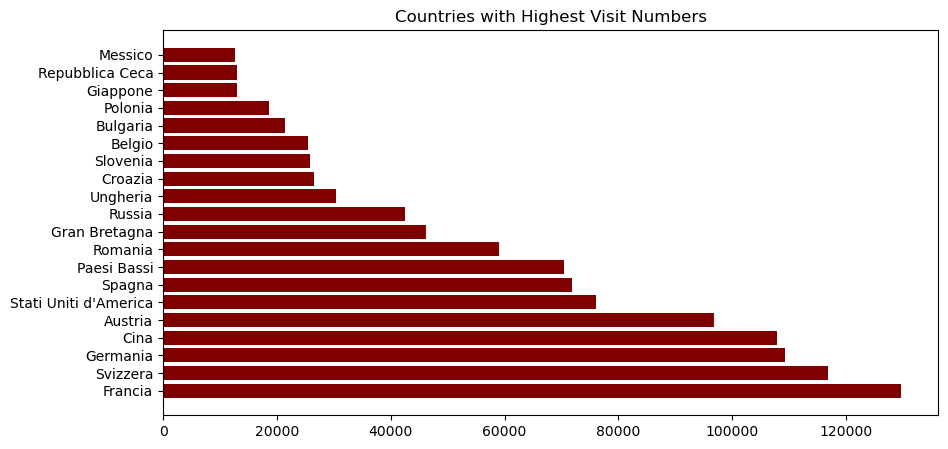

In [115]:
df = df_foreign.reset_index() # to access all the columns after the groupby 
df.sort_values(by='VISITORS', ascending=False, inplace=True) # to sort values highest to lowest
highest_countries=df.nlargest(20,'VISITORS') # get the largest 20 
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.barh(highest_countries['COUNTRY_NAME_IT'],highest_countries['VISITORS'], color ='maroon')      
plt.title('Countries with Highest Visit Numbers')  
plt.show()

In [102]:
#1.2
# merge the province name based on provience code to other data information to reach everything 
# match the province name based on province code with the other data information in the distinc_users_day
province_data = data_distinct.merge(province_code[['COD_PRO','PROVINCIA']])
# filter and get data for just the visitor which represents Italian visitors, to use in analyse 
visitors_data = province_data.loc[province_data['CUST_CLASS'] == 'visitor']
# reseting the index to not include previous dataframe index, 
# if we don't reset, it can be problem if we want to reach data with index
visitors_data = visitors_data.reset_index(drop=True)
# the total number of visitors based on each provincia, done by groupby 
# groupby is do group same provincia names' visitors' data and with sum, the total number of Italian visitors
visitor_sum = visitors_data.groupby('PROVINCIA').agg({'VISITORS': 'sum', 'PROVINCIA': 'first'})
visitor_sum = visitor_sum.reset_index(drop=True)
# population data clean and group by based on the provincia 
# since in the data sex based more than one totale it needs to be filtered
population_clean = population.loc[(population['Stato civile'] == 'totale') & (population['Sesso'] == 'totale' ) ]
# in the project, it needed just provincia names and values
population_clean = population_clean[['Territorio','Value']]
population_clean = population_clean.reset_index(drop=True)
# grouped the same name provincia names and sum the values 
population_clean = population_clean.groupby('Territorio')['Value'].sum()
# merged the population and visitor_sum based on provincia names 
merged_df = pd.merge(population_clean, visitor_sum, left_on='Territorio', right_on='PROVINCIA')
# calculatted the weighted sum with visitors divided inhabitants of the each provincias
merged_df['Weighted Sum'] = merged_df['VISITORS']/merged_df['Value']


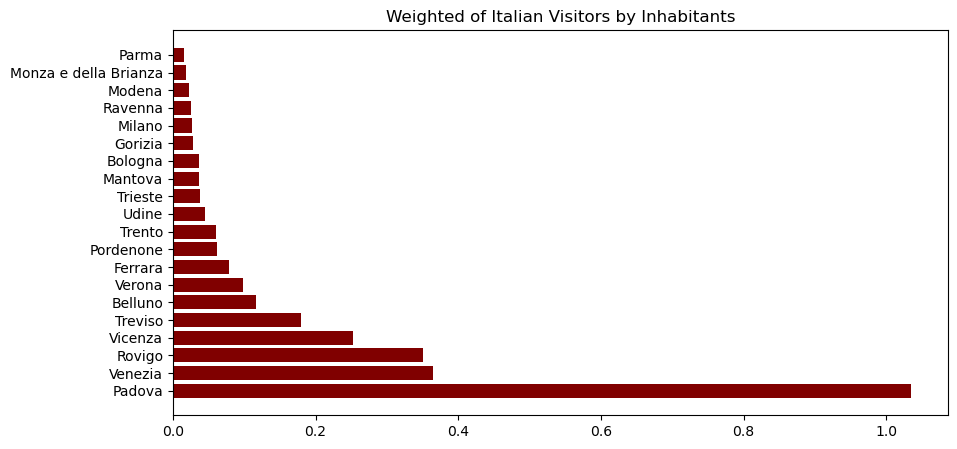

In [116]:
merged_df.sort_values(by='Weighted Sum', ascending=False, inplace=True) # to sort values highest to lowest
weighted_highest=merged_df.nlargest(20,'Weighted Sum') # get the largest 20 
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.barh(weighted_highest['PROVINCIA'],weighted_highest['Weighted Sum'], color ='maroon')
plt.title('Weighted of Italian Visitors by Inhabitants')        
plt.show()

In the second part of the analysis, the density of fluxes are analyized. Based on these analysis, some improvements about mobility towards to Padova can be done. For this part, first the provincias nearby the padova seperated based on three main highways. The data of day_od seperated and merged based on the provincias in each highways. After that, 'FLOW' column used to analysis to show movement density in each highways. 

In [104]:
# 2.1. 
# the provincias selected based on nearly provincias based on that highways 
# if the radius increased more provincia can added to the this list, it will not change the code
a13 = ['Rovigo','Ferrara','Bologna']
a4_milano = ['Vicenza','Verona']
a4_venice = ['Venezia','Treviso','Belluno']
# merged prvoince code and day_od data to get the provincia name based on provincia code 
day_merged = day.merge(province_code[['COD_PRO','PROVINCIA']])
# from each highway provincia new dataset created to looked those highways flow 
# isin function compared the each value in the list with the selected column value
# after this filtering, filtered data save to new dataframe to not be confused with other datasets 
a13_highway = day_merged.loc[day_merged['PROVINCIA'].isin(a13)]
a4milano_highway = day_merged.loc[day_merged['PROVINCIA'].isin(a4_milano)]
a4venice_highway = day_merged.loc[day_merged['PROVINCIA'].isin(a4_venice)]

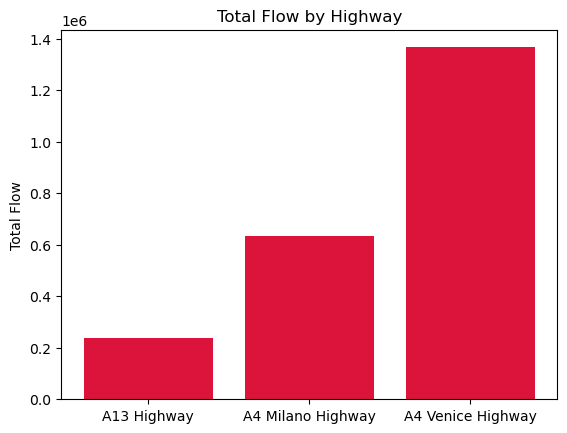

In [105]:
# sum the flow of each day and month to get proper density of flux based on highway 
a13_sum = a13_highway['FLOW'].sum()
a4milano_sum = a4milano_highway['FLOW'].sum()
a4venice_sum = a4venice_highway['FLOW'].sum()
# create bar plot from the these data to see which highway uses the fluxes more 
values = [a13_sum, a4milano_sum, a4venice_sum]
labels = ['A13 Highway', 'A4 Milano Highway', 'A4 Venice Highway']
plt.bar(labels, values, color='crimson')
plt.title('Total Flow by Highway')
plt.ylabel('Total Flow')
plt.show()

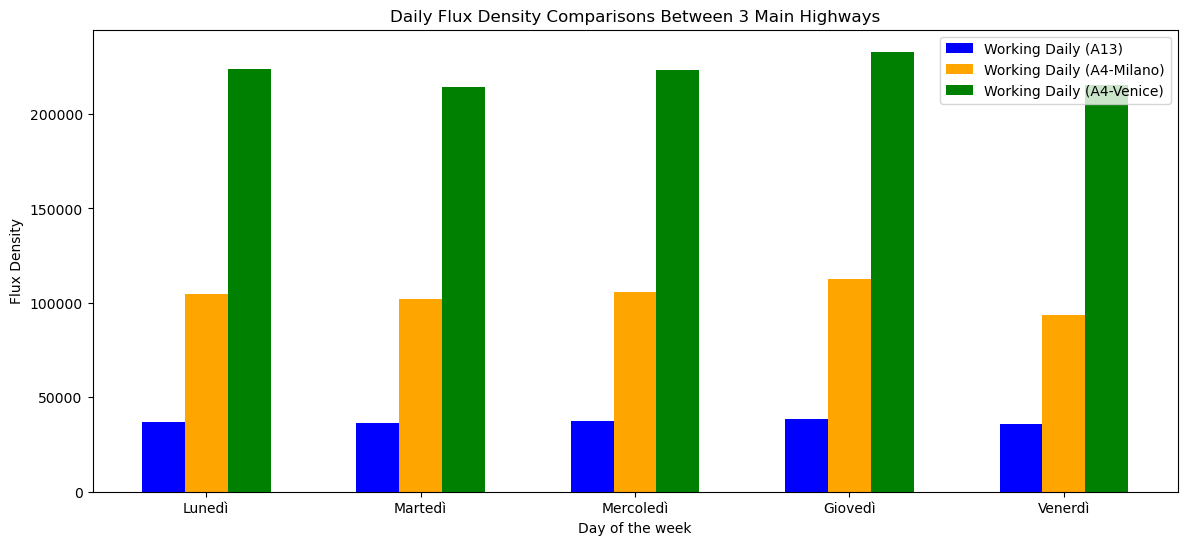

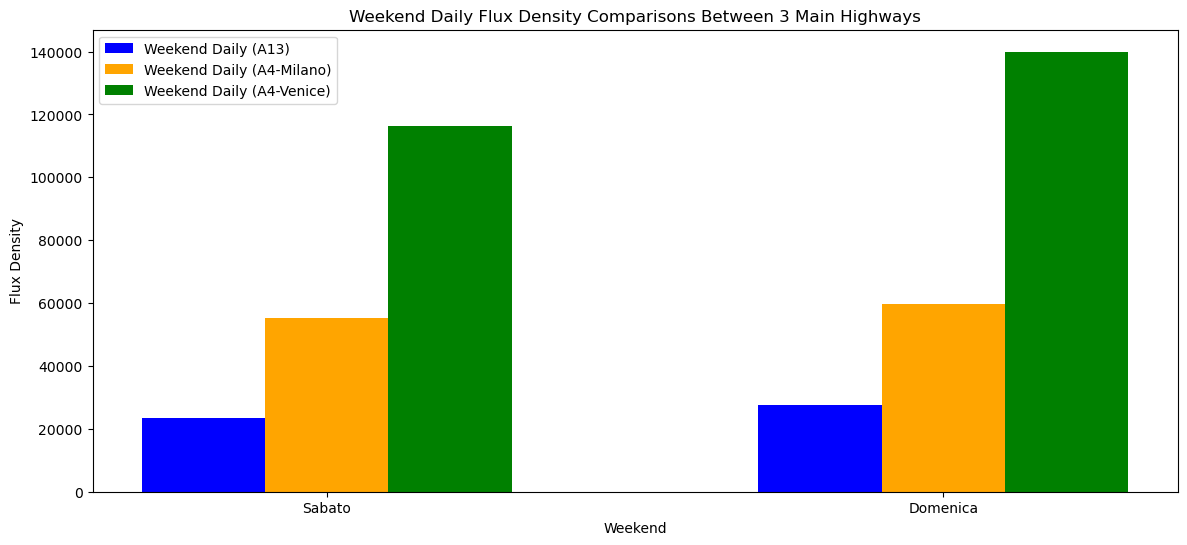

In [113]:
# 2.2. 
weekend = ['Sabato', 'Domenica']
weekdays = ['Lunedì','Martedì','Mercoledì','Giovedì','Venerdì']
# summation of weekdays daily flow density for each highways
weekday_flow = a13_highway.groupby('DOW').agg({'FLOW': 'sum', 'DOW': 'first'})
weekday_milano = a4milano_highway.groupby('DOW').agg({'FLOW': 'sum', 'DOW': 'first'})
weekday_venice = a4venice_highway.groupby('DOW').agg({'FLOW': 'sum', 'DOW': 'first'})

# each highways flow density seperated weekend and working days 
working_daily_a13 = weekday_flow.loc[weekday_flow['DOW'].isin(weekdays)]
weekend_each_a13 = weekday_flow.loc[weekday_flow['DOW'].isin(weekend)]
working_daily_milano = weekday_milano.loc[weekday_milano['DOW'].isin(weekdays)]
weekend_each_milano = weekday_milano.loc[weekday_milano['DOW'].isin(weekend)]
working_daily_venice = weekday_venice.loc[weekday_venice['DOW'].isin(weekdays)]
weekend_each_venice = weekday_venice.loc[weekday_venice['DOW'].isin(weekend)]

# grouped plot for all the highways to compare the density of flow
x = np.arange(len(weekdays))
width= 0.2
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.bar(x - width,working_daily_a13['FLOW'],width, label='Working Daily (A13)', color='blue')
ax1.bar(x ,working_daily_milano['FLOW'],width, label='Working Daily (A4-Milano)', color='orange')
ax1.bar(x + width,working_daily_venice['FLOW'],width, label='Working Daily (A4-Venice)', color='green')
ax1.set_title('Daily Flux Density Comparisons Between 3 Main Highways')
ax1.set_xlabel('Day of the week')
ax1.set_ylabel('Flux Density')
ax1.set_xticks(x, weekdays)
ax1.legend()
plt.show()

w = np.arange(len(weekend))
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.bar(w - width,weekend_each_a13['FLOW'],width, label='Weekend Daily (A13)', color='blue')
ax1.bar(w ,weekend_each_milano['FLOW'],width, label='Weekend Daily (A4-Milano)', color='orange')
ax1.bar(w + width,weekend_each_venice['FLOW'],width, label='Weekend Daily (A4-Venice)', color='green')
ax1.set_title('Weekend Daily Flux Density Comparisons Between 3 Main Highways')
ax1.set_xlabel('Weekend')
ax1.set_ylabel('Flux Density')
ax1.set_xticks(w, weekend)
ax1.legend()
plt.show()

From 2.1. and 2.2., it can be observed that the highest density belongs to A4-Venice Direction Highway. For weekend and working days give the similar results for the highest density highway. This shows that most improvement in the fluxes needs to be done in the A4-Venice direction highway. When compared the general results between, working days and weekend, in the working day there is more density in the all of the highways. The reason of this can be most people goes work out of their provincias. However, to do more clear analysis more parameters and data needed. For example, the nearby provincias radius can be increased, the destination and origin fields can be count in the data analysis. 


In [118]:
# 3. 
# data readşand converting text file to csv file to get distance data
#The distance information is in the Veneto.txt file , 
#so the file was converted to csv format in order to perform the taks more conveniently using data frame

txt_file = r"Veneto.txt"
csv_file = r"Veneto.csv"

# Open the input file in read mode and output file in write mode
with open(txt_file, 'r') as infile, open(csv_file, 'w', newline='') as outfile:
    # Read the input file and split each line on semicolon
    lines = infile.readlines()
    lines = [line.strip().split(';') for line in lines]

    # Write the split lines to the output file using csv writer
    writer = csv.writer(outfile)
    writer.writerows(lines)

In [119]:
# clear the data and replace the nan with 0 
df_dist = pd.read_csv("Veneto.csv")
distinct_users_day = distinct_users_day.fillna(0)
day_od = day_od.fillna(0)

In order to obtain distance measure from origin to distance some of the features should be matched. PRO_COM includes the number that belongs to comune. Thus, this feature was considered and used for the matching between which destination or origin belong to which province. After the group by methods was applied and the visitors for the each different distances were gathered

In [120]:

distance_matrix = pd.DataFrame({
    "ORIGIN": df_dist['"Origine"'],
    "PRO_COM": df_dist['"Destinazione"'],
    "DISTANCE": df_dist['"Total_Mete"']
})
#.strip() was used to eliminate zeros to obtain integers. For example '1042,00' is a string format then it was converted to 104200 by replacing comma .
# After zeros at the end removed. Because it is still the object type , it was changed to integer
distance_matrix["ORIGIN"]=distance_matrix["ORIGIN"].str.replace(',', '')
distance_matrix["ORIGIN"] = [s.strip("0") for s in distance_matrix["ORIGIN"]]
distance_matrix["ORIGIN"] = pd.to_numeric(distance_matrix["ORIGIN"], errors='coerce').fillna(0).astype(int)

distance_matrix["PRO_COM"]=distance_matrix["PRO_COM"].str.replace(',', '')
distance_matrix["PRO_COM"] = [s.strip("0") for s in distance_matrix["PRO_COM"]]
distance_matrix["PRO_COM"] = pd.to_numeric(distance_matrix["PRO_COM"], errors='coerce').fillna(0).astype(int)

distance_matrix["DISTANCE"]=distance_matrix["DISTANCE"].str.replace(',', '')
distance_matrix["DISTANCE"] = pd.to_numeric(distance_matrix["DISTANCE"], errors='coerce').fillna(0).astype(int)

In [121]:
# to get the data for every detailed merged distinct_users_day.csv and day_od.csv file
df = pd.merge(day_od, distinct_users_day, on=["DOW", "CUST_CLASS", "COD_COUNTRY", "COD_PRO", "PRO_COM"])
# compare the code of the provincia and provincia name to add name of the provincia into the main dataframe 
df= distinct_users_day.merge(codici_istat_provincia[['COD_PRO','PROVINCIA']])

# from the Veneto.csv, we need to compare the code of the provincia and name and commune 
# since this data gives the between origin commune destination commune distance, two step merged done first commune code and commune name 
# after from provincia code, get the provincia name  
temp = distance_matrix.merge(codici_istat_comune[['PRO_COM','COD_PRO']])
temp = temp.merge(codici_istat_provincia[['COD_PRO','PROVINCIA']])
# since our data is Padova we want to get the distance between other provincias and padova 
# so, filter the data for just Padova distances
temp_padova = temp.loc[temp['PROVINCIA']=='Padova']

# merged the distance data with the main dataframe 
new = pd.merge(df,temp_padova,left_on='PRO_COM',right_on='ORIGIN')

# grouped the data based on distance and sum the visitors to find distribution 
visitors_by_distance = new.groupby("DISTANCE")["VISITORS"].sum().reset_index()

# convert the distance meter to km 
visitors_by_distance['DISTANCE']= visitors_by_distance['DISTANCE']/1000

c:\Users\crnyl\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


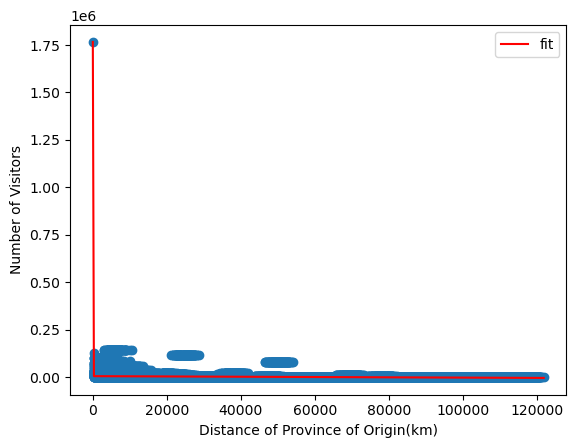

In [122]:
from scipy.optimize import curve_fit

# Define a Gaussian function to find the proper function for our figure based on distance and visitor 
# The function for the data did not obtained as expected and does not fit well .  
# A function was proposed finallly which is the sum of a Gaussian and a linear function
def func(x, a, x0, sigma, b, c):
    return a * np.exp(-(x - x0)*2 / (2 * sigma*2)) + b*x + c

# Fit the function to the data using curve_fit function 
popt, pcov = curve_fit(func, visitors_by_distance["DISTANCE"], visitors_by_distance["VISITORS"])
plt.scatter(visitors_by_distance["DISTANCE"], visitors_by_distance["VISITORS"])
plt.plot(visitors_by_distance["DISTANCE"], func(visitors_by_distance["DISTANCE"], *popt), 'r-', label='fit')
plt.xlabel("Distance of Province of Origin(km)")
plt.ylabel("Number of Visitors")
plt.legend()
plt.show()